# Ensemble Methods: Boosting
Irene Pico López

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
plt.style.use('seaborn-v0_8-darkgrid')

## 1. Carga de datos

Fechas train : 2010-04-01 00:00:00 --- 2023-12-29 00:00:00  (n=3517)
Fechas test 1 : 2024-01-02 00:00:00 --- 2024-01-31 00:00:00  (n=22)
Fechas test 2 : 2024-02-01 00:00:00 --- 2024-04-30 00:00:00  (n=62)
Fechas test 3 : 2024-05-02 00:00:00 --- 2024-07-31 00:00:00  (n=65)


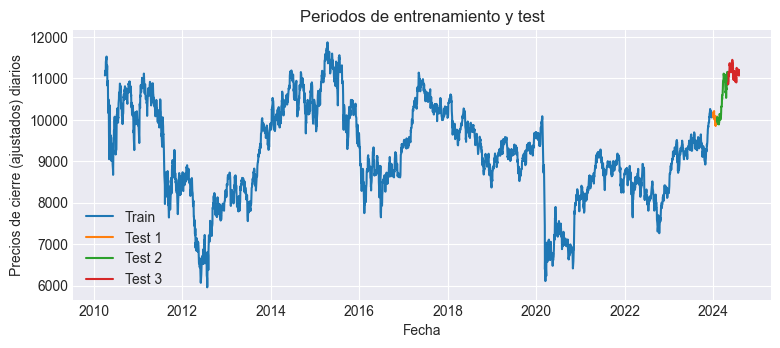

In [2]:
# Cargar los datos desde un archivo HDF5
ibex35 = pd.read_hdf('ibex35.h5', key='datos_tratados')
y = pd.DataFrame(ibex35['adj_close'])
X = ibex35.drop('adj_close', axis=1)
## TRAIN Y TEST
## train (:finTrain)
fin_train = '2023-12-31'
## test1 (enero)
ini_test1 = '2024-01-01'
fin_test1 = '2024-01-31'
## test2 (febrero-abril)
ini_test2 = '2024-02-01'
fin_test2 = '2024-04-30'
## test3 (mayo-julio) (inicioT3:)
ini_test3 = '2024-05-01'
print(
    f"Fechas train : {y.index.min()} --- {y.loc[:fin_train].index.max()}  "
    f"(n={len(y.loc[:fin_train])})"
)
print(
    f"Fechas test 1 : {y.loc[ini_test1:].index.min()} --- {y.loc[:fin_test1].index.max()}  "
    f"(n={len(y.loc[ini_test1:fin_test1])})"
)
print(
    f"Fechas test 2 : {y.loc[ini_test2:].index.min()} --- {y.loc[:fin_test2].index.max()}  "
    f"(n={len(y.loc[ini_test2:fin_test2])})"
)
print(
    f"Fechas test 3 : {y.loc[ini_test3:].index.min()} --- {y.loc[:].index.max()}  "
    f"(n={len(y.loc[ini_test3:])})"
)
## Train
y_train = y.loc[:fin_train]
X_train = X.loc[:fin_train]
## Test 
y_test = y.loc[ini_test1:]
X_test = X.loc[ini_test1:]

## Escenario 1
y_test1  = y.loc[ini_test1:fin_test1]
X_test1  = X.loc[ini_test1:fin_test1]

## Escenario 2
y_test2  = y.loc[ini_test2:fin_test2]
X_test2  = X.loc[ini_test2:fin_test2]

## Escenario 3
y_test3  = y.loc[ini_test3:]
X_test3  = X.loc[ini_test3:]


# Gráfico
# ======================================================================================
fig, ax = plt.subplots(figsize=(9, 3.5))

# Usar matplotlib directamente para más control sobre las etiquetas
ax.plot(y_train.index, y_train['adj_close'], label='Train')
ax.plot(y_test1.index, y_test1['adj_close'], label='Test 1')
ax.plot(y_test2.index, y_test2['adj_close'], label='Test 2')
ax.plot(y_test3.index, y_test3['adj_close'], label='Test 3')

# Títulos y etiquetas de los ejes
ax.set_title('Periodos de entrenamiento y test')
ax.set_xlabel('Fecha')
ax.set_ylabel('Precios de cierre (ajustados) diarios')
# Mostrar leyenda
ax.legend()
# Mostrar el gráfico
plt.show()

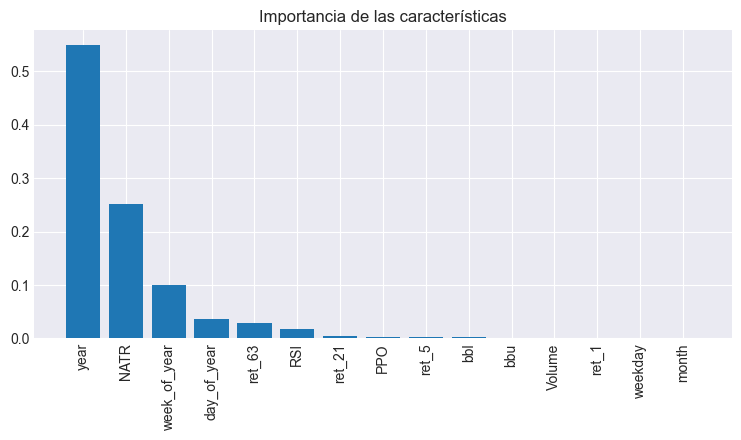

In [3]:
# Modelo XGBoost
model = XGBRegressor()

# Entrena el modelo
model.fit(X_train, y_train)

# Importancia de las características
importancias = model.feature_importances_
indices = np.argsort(importancias)[::-1]
columnas = X_train.columns

# Gráfico de importancia de características
plt.figure(figsize=(9, 4))
plt.title("Importancia de las características")
plt.bar(range(X_train.shape[1]), importancias[indices], align="center")
plt.xticks(range(X_train.shape[1]), columnas[indices], rotation=90)
plt.show()


In [4]:
## Train
X_train = X_train[['year', 'NATR', 'week_of_year', 'day_of_year', 'ret_63']]
## Test
X_test = X_test[['year', 'NATR', 'week_of_year', 'day_of_year', 'ret_63']]

## 2. Construcción del modelo

In [5]:
import time
# Modelo XGBoost
model = XGBRegressor()

# Definir los hiperparámetros a ajustar
param_distributions = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.1, 0.7, 0.8],
    'colsample_bytree': [0.7, 0.8, 1.0],
    'gamma': [0.01, 0.1, 0.2]
}

# inicio temporizador 
start_time = time.time() 
# Búsqueda de los parámetros óptimos
randomized_search = RandomizedSearchCV(estimator=model, param_distributions=param_distributions,
                                       n_iter=20, cv=8, n_jobs=-1, verbose=1, scoring='neg_mean_squared_error', random_state=42)
randomized_search.fit(X_train, y_train)

# Fin del temporizador
end_time = time.time()
total_time = end_time - start_time

print(f"Tiempo total de búsqueda: {total_time / 60:.2f} minutos")

# Mejor combinación de hiperparámetros
print("Mejores hiperparámetros:", randomized_search.best_params_)

# Modelo con los mejores hiperparámetros
best_model = randomized_search.best_estimator_

# Predicciones con el mejor modelo
y_pred = best_model.predict(X_test)

Fitting 8 folds for each of 20 candidates, totalling 160 fits
Tiempo total de búsqueda: 0.15 minutos
Mejores hiperparámetros: {'subsample': 0.7, 'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.2, 'gamma': 0.2, 'colsample_bytree': 1.0}


In [6]:
# PARTICIÓN PERIODOS
#######################################
## ESCENARIO 1
print(f'Test 1: n={len(y_pred[:22])}')
y_pred1 = pd.DataFrame(y_pred[:22], columns=['y_pred1'])
y_pred1.index = y_test1.index
print(y_pred1)
print('\n')

## ESCENARIO 2
print(f'Test 2: n={len(y_pred[22:84])}')
y_pred2 = pd.DataFrame(y_pred[22:84], columns=['y_pred2'])
y_pred2.index = y_test2.index
print(y_pred2)
print('\n')

## ESCENARIO 3
print(f'Test 3: n={len(y_pred[84:])}')
y_pred3 = pd.DataFrame(y_pred[84:], columns=['y_pred3'])
y_pred3.index = y_test3.index
print(y_pred3)

Test 1: n=22
                y_pred1
Date                   
2024-01-02  9374.161133
2024-01-03  8888.014648
2024-01-04  9100.746094
2024-01-05  9109.864258
2024-01-08  9109.676758
2024-01-09  8896.661133
2024-01-10  9015.594727
2024-01-11  9088.008789
2024-01-12  8925.514648
2024-01-15  8876.669922
2024-01-16  8975.966797
2024-01-17  9104.118164
2024-01-18  9015.916992
2024-01-19  8969.477539
2024-01-22  8968.720703
2024-01-23  8922.246094
2024-01-24  9018.959961
2024-01-25  9016.879883
2024-01-26  9014.278320
2024-01-29  9023.419922
2024-01-30  9044.188477
2024-01-31  9131.662109


Test 2: n=62
                y_pred2
Date                   
2024-02-01  9087.247070
2024-02-02  9106.764648
2024-02-05  9171.151367
2024-02-06  9100.979492
2024-02-07  9179.381836
...                 ...
2024-04-24  9341.202148
2024-04-25  9352.886719
2024-04-26  9260.988281
2024-04-29  9272.154297
2024-04-30  9400.583984

[62 rows x 1 columns]


Test 3: n=65
                y_pred3
Date                  

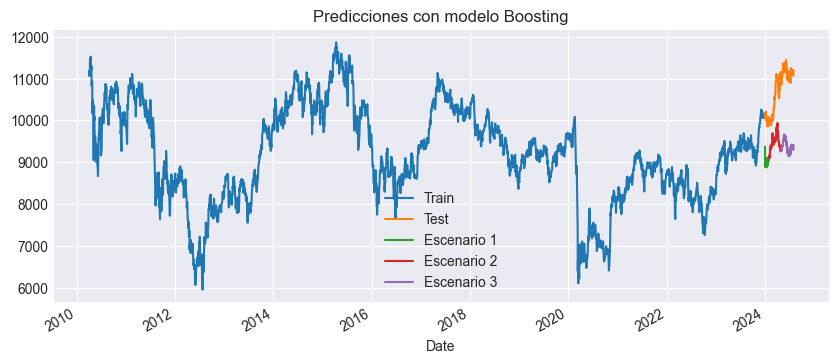

In [7]:
# Gráfico
fig, ax = plt.subplots(figsize=(10, 4))

# Graficamos los datos de entrenamiento y prueba
y_train['adj_close'].plot(ax=ax, label='Train')
y_test['adj_close'].plot(ax=ax, label='Test')

# Graficamos las predicciones convertidas en Series
y_pred1['y_pred1'].plot(ax=ax, label='Escenario 1')
y_pred2['y_pred2'].plot(ax=ax, label='Escenario 2')
y_pred3['y_pred3'].plot(ax=ax, label='Escenario 3')

ax.set_title('Predicciones con modelo Boosting')
ax.legend()
plt.show()

Se observa un rendimiento muy poco satisfactorio del modelo, por lo que se ha decidido incluir características nuevas para ver cómo estas pueden afectar los resultados.

## 3. Creación de nuevas características

In [8]:
# Cargar los datos desde un archivo HDF5
df = pd.read_hdf('ibex35.h5', key='datos_tratados')

# Creo df2 con NUEVOS INDICADORES TÉCNICOS
df2 = pd.DataFrame(index=df.index)
df2['log_ret_1'] = np.log(df['adj_close'] / df['adj_close'].shift(1))
df2['log_ret_5'] = np.log(df['adj_close'] / df['adj_close'].shift(5))
df2['volatility_21'] = df['ret_1'].rolling(window=21).std()
df2['ma_200'] = df['adj_close'].rolling(window=200).mean()
exp1 = df['adj_close'].ewm(span=12, adjust=False).mean()
exp2 = df['adj_close'].ewm(span=26, adjust=False).mean()
df2['MACD'] = exp1 - exp2

# Estandarizar df2
scaler = StandardScaler()
df2_scaled = pd.DataFrame(scaler.fit_transform(df2), index=df2.index, columns=df2.columns)

# Fusionar df y df2_scaled
ibex35 = pd.concat([df, df2_scaled], axis=1)
ibex35.dropna(inplace=True)

y = pd.DataFrame(ibex35['adj_close'])
X = ibex35.drop('adj_close', axis=1)

## Train
y_train = y.loc[:fin_train]
X_train = X.loc[:fin_train]
## Test 
y_test = y.loc[ini_test1:]
X_test = X.loc[ini_test1:]

## Escenario 1
y_test1  = y.loc[ini_test1:fin_test1]
X_test1  = X.loc[ini_test1:fin_test1]

## Escenario 2
y_test2  = y.loc[ini_test2:fin_test2]
X_test2  = X.loc[ini_test2:fin_test2]

## Escenario 3
y_test3  = y.loc[ini_test3:]
X_test3  = X.loc[ini_test3:]

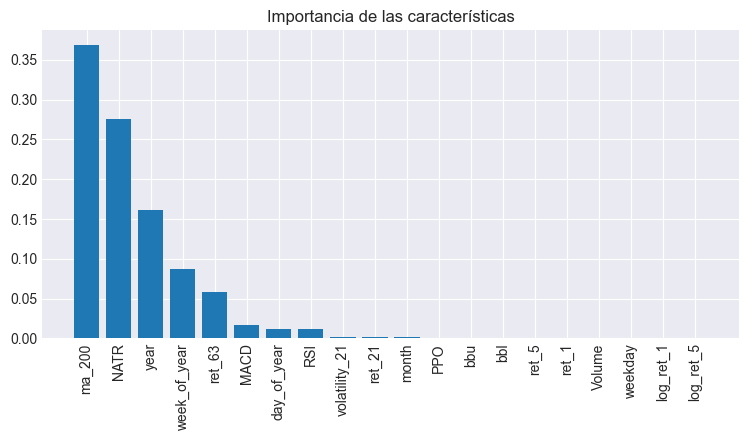

In [9]:
# Modelo XGBoost
model = XGBRegressor()

# Entrena el modelo
model.fit(X_train, y_train)

# Importancia de las características
importancias = model.feature_importances_
indices = np.argsort(importancias)[::-1]
columnas = X_train.columns

# Gráfico de importancia de características
plt.figure(figsize=(9, 4))
plt.title("Importancia de las características")
plt.bar(range(X_train.shape[1]), importancias[indices], align="center")
plt.xticks(range(X_train.shape[1]), columnas[indices], rotation=90)
plt.show()

In [10]:
## Train
X_train = X_train[['ma_200', 'NATR', 'year', 'week_of_year', 'ret_63']]

## Test
X_test = X_test[['ma_200', 'NATR', 'year', 'week_of_year', 'ret_63']]

## Construcción nuevamente del modelo

In [11]:
import time
# Modelo XGBoost
model = XGBRegressor()

# Definir los hiperparámetros a ajustar
param_distributions = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.1, 0.7, 0.8],
    'colsample_bytree': [0.7, 0.8, 1.0],
    'gamma': [0.01, 0.1, 0.2]
}

# inicio temporizador 
start_time = time.time() 
# Búsqueda de los parámetros óptimos
randomized_search = RandomizedSearchCV(estimator=model, param_distributions=param_distributions,
                                       n_iter=20, cv=8, n_jobs=-1, verbose=1, scoring='neg_mean_squared_error', random_state=42)
randomized_search.fit(X_train, y_train)

# Fin del temporizador
end_time = time.time()
total_time = end_time - start_time

print(f"Tiempo total de búsqueda: {total_time / 60:.2f} minutos")

# Mejor combinación de hiperparámetros
print("Mejores hiperparámetros:", randomized_search.best_params_)

# Modelo con los mejores hiperparámetros
best_model = randomized_search.best_estimator_

# Predicciones con el mejor modelo
y_pred = best_model.predict(X_test)

Fitting 8 folds for each of 20 candidates, totalling 160 fits
Tiempo total de búsqueda: 0.07 minutos
Mejores hiperparámetros: {'subsample': 0.1, 'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.1, 'gamma': 0.01, 'colsample_bytree': 0.7}


In [12]:
# PARTICIÓN PERIODOS
#######################################
## ESCENARIO 1
print(f'Test 1: n={len(y_pred[:22])}')
y_pred1 = pd.DataFrame(y_pred[:22], columns=['y_pred1'])
y_pred1.index = y_test1.index
print(y_pred1)
print('\n')

## ESCENARIO 2
print(f'Test 2: n={len(y_pred[22:84])}')
y_pred2 = pd.DataFrame(y_pred[22:84], columns=['y_pred2'])
y_pred2.index = y_test2.index
print(y_pred2)
print('\n')

## ESCENARIO 3
print(f'Test 3: n={len(y_pred[84:])}')
y_pred3 = pd.DataFrame(y_pred[84:], columns=['y_pred3'])
y_pred3.index = y_test3.index
print(y_pred3)

Test 1: n=22
                 y_pred1
Date                    
2024-01-02  10144.549805
2024-01-03  10125.553711
2024-01-04  10112.315430
2024-01-05  10152.551758
2024-01-08  10057.992188
2024-01-09   9847.755859
2024-01-10   9851.424805
2024-01-11   9786.579102
2024-01-12   9832.906250
2024-01-15   9841.892578
2024-01-16   9821.519531
2024-01-17   9820.637695
2024-01-18   9839.987305
2024-01-19   9873.721680
2024-01-22   9865.866211
2024-01-23   9824.750977
2024-01-24   9934.782227
2024-01-25   9837.609375
2024-01-26   9927.706055
2024-01-29   9989.570312
2024-01-30  10088.640625
2024-01-31  10074.108398


Test 2: n=62
                 y_pred2
Date                    
2024-02-01   9998.022461
2024-02-02   9969.063477
2024-02-05   9938.151367
2024-02-06  10009.700195
2024-02-07   9975.863281
...                  ...
2024-04-24  10397.744141
2024-04-25  10384.326172
2024-04-26  10420.614258
2024-04-29  10413.468750
2024-04-30  10228.939453

[62 rows x 1 columns]


Test 3: n=65
         

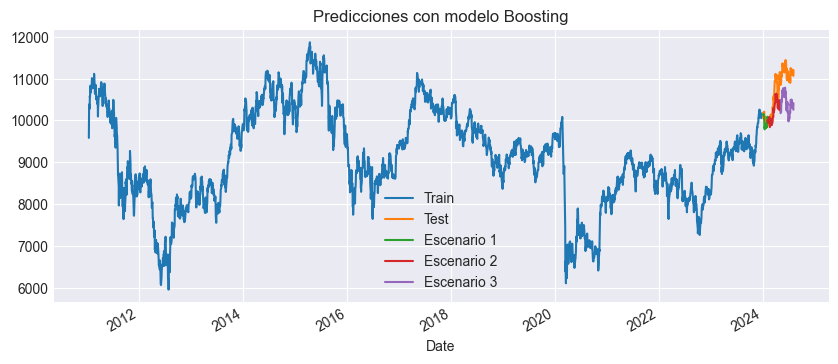

In [13]:
# Gráfico
fig, ax = plt.subplots(figsize=(10, 4))

# Graficamos los datos de entrenamiento y prueba
y_train['adj_close'].plot(ax=ax, label='Train')
y_test['adj_close'].plot(ax=ax, label='Test')

# Graficamos las predicciones convertidas en Series
y_pred1['y_pred1'].plot(ax=ax, label='Escenario 1')
y_pred2['y_pred2'].plot(ax=ax, label='Escenario 2')
y_pred3['y_pred3'].plot(ax=ax, label='Escenario 3')

ax.set_title('Predicciones con modelo Boosting')
ax.legend()
plt.show()

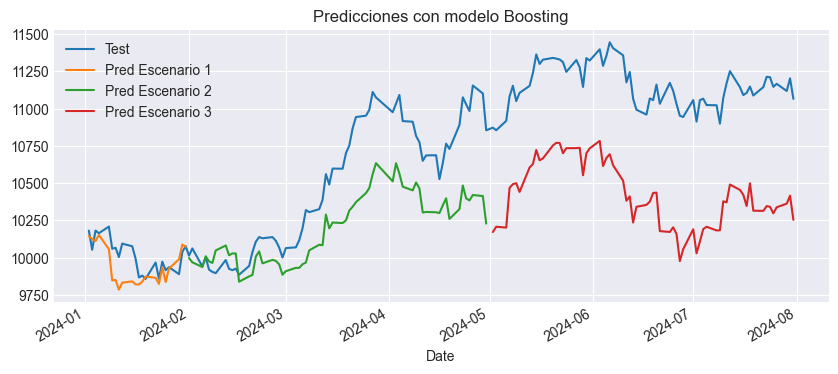

In [14]:
# Gráfico
fig, ax = plt.subplots(figsize=(10, 4))

# Graficamos los datos prueba
y_test['adj_close'].plot(ax=ax, label='Test')

# Graficamos las predicciones convertidas en Series
y_pred1['y_pred1'].plot(ax=ax, label='Pred Escenario 1')
y_pred2['y_pred2'].plot(ax=ax, label='Pred Escenario 2')
y_pred3['y_pred3'].plot(ax=ax, label='Pred Escenario 3')

ax.set_title('Predicciones con modelo Boosting')
ax.legend()
plt.show()

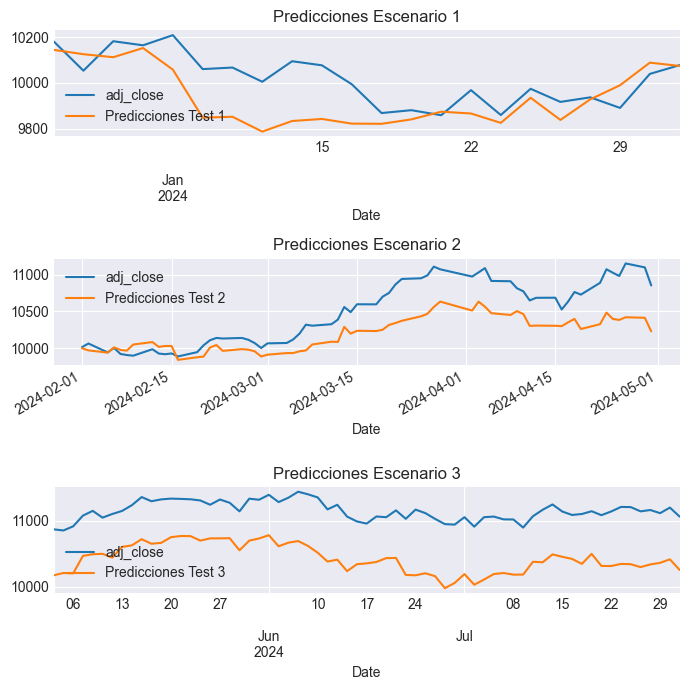

In [15]:
# Crear una figura con tres subplots
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(7, 7))

# Escenario 1
y_test1.plot(ax=axes[0], label='Adj Close')
y_pred1['y_pred1'].plot(ax=axes[0], label='Predicciones Test 1')
axes[0].set_title('Predicciones Escenario 1')
axes[0].legend()

# Escenario 2
y_test2.plot(ax=axes[1], label='Datos de prueba (Test 2)')
y_pred2['y_pred2'].plot(ax=axes[1], label='Predicciones Test 2')
axes[1].set_title('Predicciones Escenario 2')
axes[1].legend()

# Escenario 3
y_test3.plot(ax=axes[2], label='Datos de prueba (Test 3)')
y_pred3['y_pred3'].plot(ax=axes[2], label='Predicciones Test 3')
axes[2].set_title('Predicciones Escenario 3')
axes[2].legend()

# Ajustar espacio entre los subplots para que no se superpongan los títulos y etiquetas
plt.tight_layout()
plt.show()

## 3. Métricas de validación

In [16]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Calcular métricas para predicciones de statsmodels
## ESCENARIO 1
mae_SVM = mean_absolute_error(y_test1, y_pred1)
mse_SVM = mean_squared_error(y_test1, y_pred1)
rmse_SVM = np.sqrt(mse_SVM)
print("Métricas de validación (Escenario 1):")
print(f"MAE: {mae_SVM:.4f}")
print(f"MSE: {mse_SVM:.4f}")
print(f"RMSE: {rmse_SVM:.4f}")
print('\n')

## ESCENARIO 2
mae_SVM = mean_absolute_error(y_test2, y_pred2)
mse_SVM = mean_squared_error(y_test2, y_pred2)
rmse_SVM = np.sqrt(mse_SVM)
print("Métricas de validación (Escenario 2):")
print(f"MAE: {mae_SVM:.4f}")
print(f"MSE: {mse_SVM:.4f}")
print(f"RMSE: {rmse_SVM:.4f}")
print('\n')

## ESCENARIO 3
mae_SVM = mean_absolute_error(y_test3, y_pred3)
mse_SVM = mean_squared_error(y_test3, y_pred3)
rmse_SVM = np.sqrt(mse_SVM)
print("Métricas de validación (Escenario 3):")
print(f"MAE: {mae_SVM:.4f}")
print(f"MSE: {mse_SVM:.4f}")
print(f"RMSE: {rmse_SVM:.4f}")

Métricas de validación (Escenario 1):
MAE: 98.9841
MSE: 16514.2675
RMSE: 128.5079


Métricas de validación (Escenario 2):
MAE: 305.0234
MSE: 131137.0884
RMSE: 362.1286


Métricas de validación (Escenario 3):
MAE: 728.5515
MSE: 545042.6647
RMSE: 738.2700
